In [1]:

!pip install tensorflow-gpu

In [40]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark =SparkSession.builder \
  .master('local[*]') \
  .appName('conversions') \
  .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.2') \
  .getOrCreate() 
sqlContext = SQLContext(spark)

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [41]:
# # Data comes from:
# # https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# # csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

df = (spark.read.format('bigquery').option('table', 'historical_data_set.nft_detail_data')
                        .option('header' , 'true')
                        .option("inferSchema", "true")
                        .load())

In [42]:
df_Axie = df.where(df['Collection'] == 'Axie')
# df_Axie.select(col('Datetime_updated_seconds')).show(50)
df_Axies_data = df_Axie.select(col("Market"),col("Collection"),col("Category"),col("Price_USD"),to_date(col("Datetime_updated_seconds"),"yyyy-MM-dd HH:mm:ss").alias("date"))
df_Axies_prices = df_Axie.select(col("Price_USD"), to_date(col("Datetime_updated_seconds"),"yyyy-MM-dd HH:mm:ss").alias("date"))
# df_Axies_dates = df_Axie.select(to_date(col("Datetime_updated_seconds"),"yyyy-MM-dd HH:mm:ss").alias("date"))


In [43]:
df_Axies_prices.count()


38977

In [44]:
df234 = df_Axies_prices.dropna()
df234.count()

38977

In [45]:
df_Axies_prices.show(100)

+------------------+----------+
|         Price_USD|      date|
+------------------+----------+
|25.033050000000006|2019-10-14|
|       17.61566457|2019-10-14|
| 25.69235666666667|2019-10-14|
|          1.094037|2019-10-14|
|0.9286737881944443|2019-10-14|
| 1.242831697916667|2019-10-14|
| 1.242857452083333|2019-10-14|
|1.1489334370370372|2019-10-14|
|           1.29801|2019-10-14|
|           1.48344|2019-10-14|
|           1.29801|2019-10-14|
|           0.92715|2019-10-14|
|           0.92715|2019-10-14|
|1.5761550000000002|2019-10-14|
|    1.470633740625|2019-10-14|
|1.0532005494791663|2019-10-14|
|     0.96651524375|2019-10-14|
|           1.48344|2019-10-14|
| 2.409795913194445|2019-10-14|
|1.8809394661458327|2019-10-14|
|12.654600000000002|2019-10-13|
|           1.26546|2019-10-13|
| 3.873446541898149|2019-10-13|
|            4.5195|2019-10-13|
|           1.17507|2019-10-13|
|1.0990264831944443|2019-10-13|
|          1.066602|2019-10-13|
|          1.066602|2019-10-13|
|       

In [46]:
import numpy as np,pandas as pd, matplotlib.pyplot as plt
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

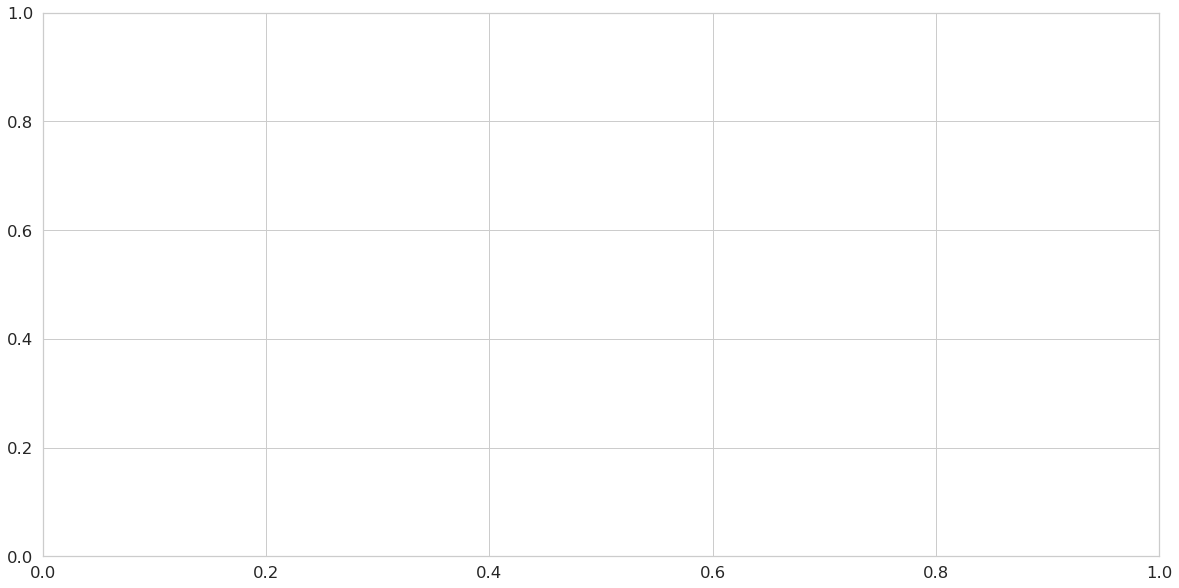

In [ ]:
df_Axies_dates = df_Axie.select(to_date(col("Datetime_updated_seconds"),"yyyy-MM-dd HH:mm:ss").alias("date"))

plt.figure(figsize=(20,10))
plt.plot(df_Axies_prices, df_Axies_dates)
plt.show()

In [47]:
print((df_Axies_prices.count(), len(df_Axies_prices.columns)))

ERROR! Session/line number was not unique in database. History logging moved to new session 163
(38977, 2)


In [48]:

# df2.select('sum(Price_USD)').show()
# con = axie.select('Price_USD')
# owners = [df2.select('sum(Price_USD)').collect()[1][0],df2.select('sum(Price_USD)').collect()[0][0]]
# con = df2.

df_Axies_prices.show(5)

+------------------+----------+
|         Price_USD|      date|
+------------------+----------+
|25.033050000000006|2019-10-14|
|       17.61566457|2019-10-14|
| 25.69235666666667|2019-10-14|
|          1.094037|2019-10-14|
|0.9286737881944443|2019-10-14|
+------------------+----------+
only showing top 5 rows



In [49]:
df_Axies_dates.count()

38977

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

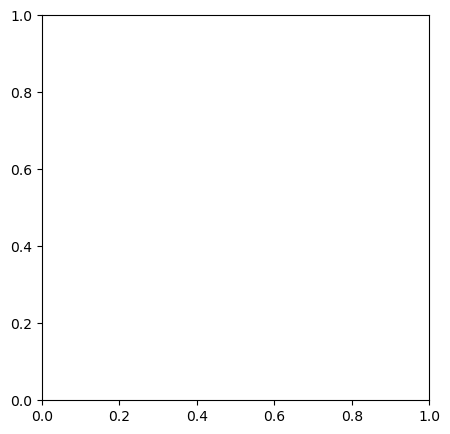

In [11]:

# dates = ['2017','2018', '2019']
plt.style.use('default')
plt.figure(figsize=(5,5))
p =plt.bar(df_Axies_prices,df_Axies_dates,width=0.45,color='#db4444')
plt.ylim(0,1400000)
plt.title("Price Trend of NFTs")
plt.bar_label(p)
plt.xlabel('Date')
plt.ylabel('NFT Price')
plt.show()


# Normalization

In [50]:
df_Axies_prices.select("Price_USD").show()

+------------------+
|         Price_USD|
+------------------+
|25.033050000000006|
|       17.61566457|
| 25.69235666666667|
|          1.094037|
|0.9286737881944443|
| 1.242831697916667|
| 1.242857452083333|
|1.1489334370370372|
|           1.29801|
|           1.48344|
|           1.29801|
|           0.92715|
|           0.92715|
|1.5761550000000002|
|    1.470633740625|
|1.0532005494791663|
|     0.96651524375|
|           1.48344|
| 2.409795913194445|
|1.8809394661458327|
+------------------+
only showing top 20 rows



In [31]:
scaler = MinMaxScaler()

In [53]:
from pyspark.ml.feature import StandardScaler
Scalerizer=StandardScaler().setInputCol("Price_USD").setOutputCol("Scaled_features")
Scalerizer.fit(df_Axies_prices.select("Price_USD")).transform(scaleDF).show()

IllegalArgumentException: requirement failed: Column Price_USD must be of type class org.apache.spark.ml.linalg.VectorUDT:struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but was actually class org.apache.spark.sql.types.StringType$:string.

In [51]:
close_price = df_Axies_prices.select("Price_USD").reshape(-1, 1)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [35]:
scaled_close = scaler.fit_transform(close_price)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [86]:
scaled_close.shape

(3201, 1)

In [87]:
np.isnan(scaled_close).any()

False

In [88]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [89]:
scaled_close = scaled_close.reshape(-1, 1)

In [90]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [91]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [92]:
X_train.shape

(2945, 99, 1)

In [93]:
X_test.shape

(156, 99, 1)

# Model

In [94]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

In [95]:


model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [96]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
42/42 [==============================] - 104s 2s/step - loss: 0.0020 - val_loss: 0.0061
Epoch 2/50
42/42 [==============================] - 58s 1s/step - loss: 0.0102 - val_loss: 0.0056
Epoch 3/50
42/42 [==============================] - 57s 1s/step - loss: 0.0043 - val_loss: 0.0356
Epoch 4/50
42/42 [==============================] - 57s 1s/step - loss: 0.0070 - val_loss: 0.0353
Epoch 5/50
42/42 [==============================] - 58s 1s/step - loss: 0.0142 - val_loss: 0.0742
Epoch 6/50
42/42 [==============================] - 58s 1s/step - loss: 0.0101 - val_loss: 0.0113
Epoch 7/50
42/42 [==============================] - 62s 1s/step - loss: 0.0070 - val_loss: 0.0313
Epoch 8/50
42/42 [==============================] - 60s 1s/step - loss: 0.0121 - val_loss: 0.0572
Epoch 9/50
42/42 [==============================] - 57s 1s/step - loss: 0.0121 - val_loss: 0.0377
Epoch 10/50
42/42 [==============================] - 57s 1s/step - loss: 0.0039 - val_loss: 0.0012
Epoch 11/50
42/42 

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 1s 151ms/step - loss: 0.0018


0.0017723538912832737

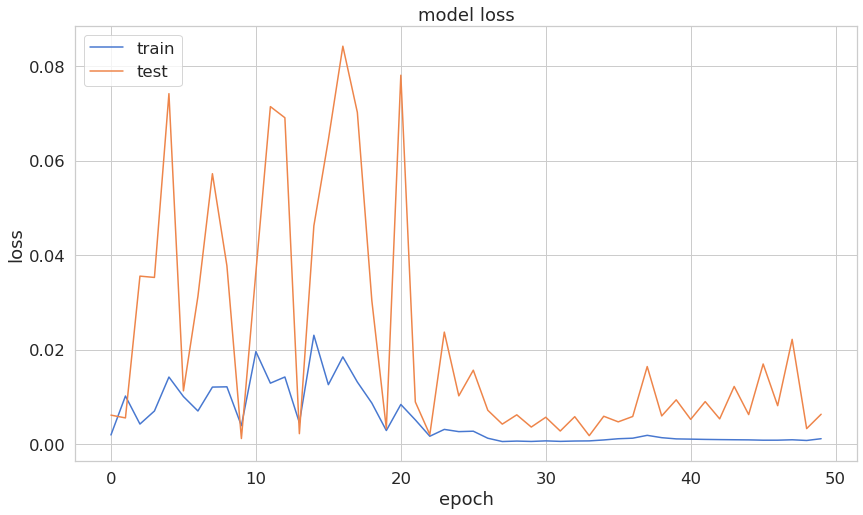

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

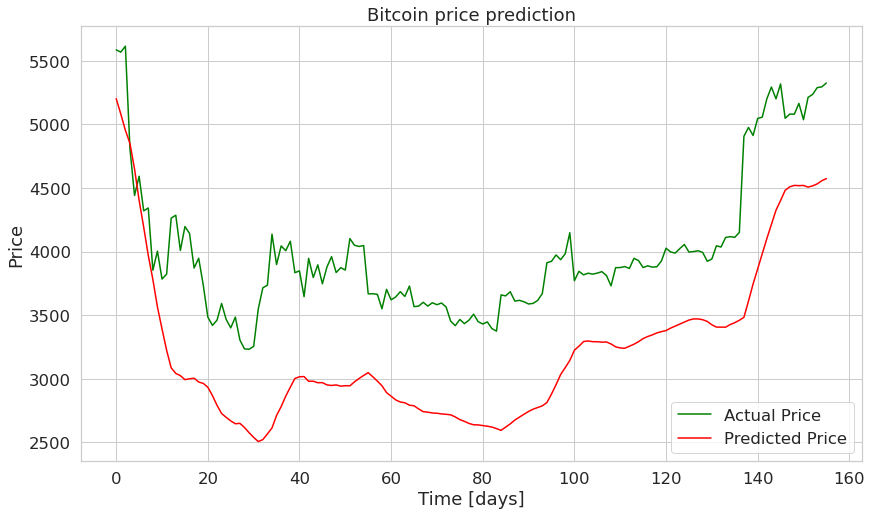

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();